In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns

from stochastic.processes.diffusion import VasicekProcess

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
OU_SPEED = 1
OU_MEAN = 100
OU_VOL = 2

OU_PRICE_STEP = 0.1
OU_PRICE_MAX_DEV = 8

TRAIN_HISTORY_LEN = 5_000_000
VAL_HISTORY_LEN = 100_000
TEST_HISTORY_LEN = 200_000
EPISODE_LEN = 10192

MAX_HOLDING = 3

EXPLORATION_EPSILON = 0.1

TD_N_EPOCHS = 10000
# TD_N_EPISODES = 25 # HOMEWORK
TD_GAMMA = 0.9 # REWARDS DISCOUNT FACTOR
TD_LR = 0.01

---

# Data preparation: create a format compatible with RL environment

In [3]:
class OUDataProvider:
    def __init__(self,speed,mean,vol,price_step,price_max_dev,history_len,episode_len):
        self.speed = speed
        self.mean = mean
        self.vol = vol
        self.price_step = price_step
        self.price_max_dev = price_max_dev
        self.history_len = history_len
        self.episode_len = episode_len
        
        vp = VasicekProcess(speed=self.speed,mean=self.mean,vol=self.vol,t=episode_len)
        self.history = pd.Series(vp.sample(self.history_len,self.mean),vp.times(self.history_len)).to_frame('price')
        self.history['level'] = (((self.history['price']-self.mean)/self.price_step).round()).astype(int).clip(-self.price_max_dev,self.price_max_dev)
    
    def __len__(self):
        return self.history_len - self.episode_len + 1
    
    def __getitem__(self,i):
        return self.history.iloc[i:i+self.episode_len]
    
    def price_to_level(self,price):
        price_level = int(np.round((price-self.mean)/self.price_step))
        return -self.price_max_dev if price_level < -self.price_max_dev else self.price_max_dev if price_level > self.price_max_dev else price_level

---

# RL Environment

In [4]:
class Agent:
    def __init__(self,max_holding,transaction_fee:float=0):
        self.max_holding = max_holding
        self.transaction_fee = transaction_fee
        
        self.possible_holdings = list(range(-self.max_holding,1+self.max_holding))
        self.n_states = len(self.possible_holdings)
        
        self.reset()
    
    def reset(self,holding=None):
        self.holding = holding or 0
        self.cash = 0.
        self.price = None
        
        self.track = list() # here we put all history of agent's activity
    
    def value(self):
        return self.cash + self.holding * self.price
    
    def holding_to_state(self,holding):
        return holding + self.max_holding
    
    def state_to_holding(self,state):
        return state - self.max_holding
    
    def is_action_available(self,quantity:int):
        return self.holding + quantity <= self.max_holding and self.holding + quantity >= -self.max_holding
    
    def act(self,price:float,quantity:int):
        """
        execute a trade by `price` in amount of `quantity`
        """
        
        holding = self.holding
        
        if abs(quantity):
            transaction_cost = price * abs(quantity) * self.transaction_fee
            current_reward = self.holding * (price-self.price) if self.price is not None else 0.
            current_reward -= transaction_cost

            self.holding += quantity
            self.cash -= price * quantity + transaction_cost
        else:
            current_reward = 0.
            
        self.price = price # refresh agent's information about current price
        
        self.track.append( (holding,price,quantity,current_reward,self.value()) )

In [5]:
class Episode:
    def __init__(self,data):
        self.data = data
        self.reset()
    
    def reset(self):
        self.t = 0
    
    def item(self):
        return self.data.iloc[self.t]
    
    def price(self):
        return self.item().price
    
    def level(self):
        return int(self.item().level)
    
    def finished(self):
        return self.t + 1 >= self.data.shape[0]
    
    def next(self):
        if self.finished():
            return False
        else:
            self.t += 1
            return True

class Market:
    def __init__(self,data_provider:OUDataProvider):
        self.data_provider = data_provider
        
        self.possible_levels = list(range(-self.data_provider.price_max_dev,1+self.data_provider.price_max_dev))
        self.n_states = len(self.possible_levels)
        
    def level_to_state(self,level):
        return level + self.data_provider.price_max_dev
    
    def state_to_level(self,state):
        return state - self.data_provider.price_max_dev
        
    def price_to_state(self,price):
        return self.level_to_state(self.data_provider.price_to_level(price))
    
    def n_episodes(self):
        return len(self.data_provider)
    
    def init_episode(self,i=None): # if i is None, then we take random episode
        if i is None:
            i = random.randint(0,len(self.data_provider))
        return Episode(self.data_provider[i])

In [6]:
class Model:
    def __init__(self,market:Market,agent:Agent):
        self.market = market
        self.agent = agent
        
        self.n_price_levels = self.market.n_states
        self.n_holding_levels = self.agent.n_states
        self.n_states = self.n_price_levels * self.n_holding_levels

        # all possible actions of agent in the existing framework ranges from
        # selling 6 units
        # to
        # buying 6 units
        # (this makes up 13 options in our example)
        # however, at any given point not all of these actions are eligible
        
        self.possible_quantities = list(range(-2*self.agent.max_holding,1+2*self.agent.max_holding))
        self.n_actions = len(self.possible_quantities)
        # action indexed 0 - sell 6 units
        # ...
        # action indexed 12 - buy 6 units
    
    def state_2d_to_1d(self,price_level,holding):
        market_state = self.market.level_to_state(price_level)
        holding_state = self.agent.holding_to_state(holding)
        return market_state * self.n_holding_levels + holding_state
    
    def state_1d_to_2d(self,state):
        market_state = state // self.n_holding_levels
        price_level = self.market.state_to_level(market_state)
        
        holding_state = state % self.n_holding_levels
        holding = self.agent.state_to_holding(holding_state)
        
        return (price_level,holding)
    
    def quantity_to_action(self,quantity):
        return quantity + 2*self.agent.max_holding
    
    def action_to_quantity(self,action):
        return action - 2*self.agent.max_holding
    
    def eligible_actions(self,state):
        price_level,holding = self.state_1d_to_2d(state)
        min_quantity = -self.agent.max_holding - holding
        max_quantity = self.agent.max_holding - holding
        return [self.quantity_to_action(quantity) for quantity in range(min_quantity,1+max_quantity)]
    
    def generate_Q(self):
        Q = np.array([np.isin(np.arange(self.n_actions),self.eligible_actions(state)).astype(float) for state in range(self.n_states)])
        return np.where(Q==1,0,np.nan)

In [7]:
class Policy:
    def __init__(self,model,Q):
        self.model = model
        self.Q = Q
    
    def random_action(self,state):
        eligible_actions = np.where(np.isfinite(self.Q[state]))[0]
        return random.choice(eligible_actions)
    
    def best_action(self,state):
        q = self.Q[state]
        eligible_actions = np.where(np.isfinite(q))[0]
        q = q[eligible_actions]
        argmax = np.where(q==q.max())[0]
        return eligible_actions[random.choice(argmax)]
    
    def epsilon_greedy_action(self,state,epsilon):
        if random.uniform(0,1) < epsilon:
            return self.random_action(state)
        else:
            return self.best_action(state)
    
    def evaluate(self,episode): # evaluate episode
        self.model.agent.reset()
        episode.reset()
        
        while not episode.finished():
            state = self.model.state_2d_to_1d(episode.level(),self.model.agent.holding) # read current state of model
            action = self.best_action(state) # determine best action from given model state
            quantity = self.model.action_to_quantity(action) # determine amount of asset we need to execute on the market
            self.model.agent.act(episode.price(),quantity) # send order
            
            episode.next()
        
        return pd.DataFrame(self.model.agent.track,columns=['holding','price','quantity','reward','value'])
    
    def run(self,episode,epsilon,holding=None): # episode run
        states,actions = list(),list()
        
        self.model.agent.reset(holding or random.randint(-self.model.agent.max_holding,self.model.agent.max_holding))
        episode.reset()
        while not episode.finished():
            state = self.model.state_2d_to_1d(episode.level(),self.model.agent.holding) # read current state of model
            states.append(state)
            
            action = self.epsilon_greedy_action(state,epsilon)
            actions.append(action)
            
            quantity = self.model.action_to_quantity(action)
            self.model.agent.act(episode.price(),quantity)
            
            episode.next()
        
        rewards = [item[3] for item in self.model.agent.track]
        
        return pd.DataFrame({
            'state' : states,
            'action' : actions,
            'reward' : rewards
        })

---

In [8]:
train_data = OUDataProvider(
    speed = OU_SPEED,
    mean = OU_MEAN,
    vol = OU_VOL,
    price_step = OU_PRICE_STEP,
    price_max_dev = OU_PRICE_MAX_DEV,
    history_len = TRAIN_HISTORY_LEN,
    episode_len = EPISODE_LEN,
)

val_data = OUDataProvider(
    speed = OU_SPEED,
    mean = OU_MEAN,
    vol = OU_VOL,
    price_step = OU_PRICE_STEP,
    price_max_dev = OU_PRICE_MAX_DEV,
    history_len = VAL_HISTORY_LEN,
    episode_len = VAL_HISTORY_LEN,
)

test_data = OUDataProvider(
    speed = OU_SPEED,
    mean = OU_MEAN,
    vol = OU_VOL,
    price_step = OU_PRICE_STEP,
    price_max_dev = OU_PRICE_MAX_DEV,
    history_len = TEST_HISTORY_LEN,
    episode_len = TEST_HISTORY_LEN,
)

In [9]:
agent = Agent(MAX_HOLDING,transaction_fee=10e-4)

test_model = Model(market=Market(test_data),agent=agent)
test_P = Policy(test_model,Q)
train_model = Model(market=Market(train_data),agent=agent)
val_model = Model(market=Market(val_data),agent=agent)
test_model = Model(market=Market(test_data),agent=agent)

val_episode = val_model.market.init_episode(0)

In [ ]:
"""
Situation to consider

initial_state -> (action) -> new_state => here we have 1-step reward (in our case it is pnl for one time unit)

VALUE(inital_state) needs to be recalculated in the following way:

VALUE(initial_state) := VALUE(initial_state) + lr * (REWARD(new_state) + gamma * VALUE(new_state) - VALUE(initial_state))
by opening brackets we obtain
VALUE(initial_state) := VALUE(initial_state) * (1-lr) + lr * (REWARD(new_state) + gamma * VALUE(new_state))

"""

In [10]:
Q = train_model.generate_Q()

In [11]:
train_P = Policy(train_model,Q)
val_P = Policy(val_model,Q)

Let's do one iteration

In [187]:
# our goal as for now to collect history of agent activity in the following way
# (state,action,new_state,reward associated with this action)

"""
in our concrete example it should be the following list:
[
    (5,2,1,-0.375),
    (1,9,4,-0.188),
    (4,3,1,-0.396),
    (1,5,0,-0.358)
]
"""

activity = list(zip(run['state'],run['action'],run.shift(-1)['state'].fillna(0).astype(int),run.shift(-1)['reward']))[:-1]

In [ ]:
activity

In [189]:
# VALUE(initial_state) := VALUE(initial_state) * (1-lr) + lr * (REWARD(new_state) + gamma * VALUE(new_state))

"""
example : for the first item in the activity:
(5, 2, 1, -0.37457722969903673)

Q[5,2] = (1-lr) * Q[5,2] + lr * (-0.375 + gamma * max(Q[1]))
"""

'\nexample : for the first item in the activity:\n(5, 2, 1, -0.37457722969903673)\n\nQ[5,2] = (1-lr) * Q[5,2] + lr * (-0.375 + gamma * max(Q[1]))\n'

In [190]:
# Comment from Chingis:
# We may consider running this snipped several times (fixed number) so that we make a deeper propagation
# But there is no sense to run it until Q stabilizes, because by doing this we overfit for a single episode, and after switching episode we need to recalibrate Q again

for state_before,action,state_after,reward in activity:
    Q[state_before,action] = (1-TD_LR) * Q[state_before,action] + TD_LR * (reward + TD_GAMMA * np.nanmax(Q[state_after]))

In [ ]:
%%time
# This comes from Monte-Carlo algorithm, modify it for TD

MAX_HOLDING = 3
EXPLORATION_EPSILON = 0.8
TD_N_EPOCHS = 100
TD_N_EPISODES = 25 # HOMEWORK
TD_GAMMA = 0.9 # REWARDS DISCOUNT FACTOR
TD_LR = 0.01

# V = dict()

val_pnl_history = list()
for epoch in range(TD_N_EPOCHS):
    # calculate value of each (state,action) cell
    # first visit algorithm
    
    # a) <==================================#
    train_episodes = list()
    for i in range(TD_N_EPISODES):
        train_episode = train_model.market.init_episode()
        train_episodes.append(train_episode)
        
        run = train_P.run(train_episode,EXPLORATION_EPSILON/(i/10 + 1))
        #========================#
        
        activity = list(zip(run['state'],run['action'],run.shift(-1)['state'].fillna(0).astype(int),run.shift(-1)['reward']))[:-1]
        for state_before, action, state_after, reward in activity:
            Q[state_before, action] = (1-TD_LR) * Q[state_before,action] + TD_LR * (reward + TD_GAMMA * np.nanmax(Q[state_after]))
            
        #========================#
        
#         for item in run[['state','action']].drop_duplicates().to_numpy():
#             if tuple(item) not in V:
#                 V[tuple(item)] = list()
            
#             t = run[(run.state==item[0])&(run.action==item[1])].iloc[0].name
#             r = run.loc[t:].iloc[1:].reward.values
#             f = np.power(MC_GAMMA,np.arange(0,r.size))
            
#             V[tuple(item)].append( (r*f).sum() )
        
#     # refresh values of Q
#     for (state,action),vals in V.items():
#         Q[state,action] = np.mean(vals)
    
    best_total_reward = None
    best_evaluation = None
    for train_episode in train_episodes:
        train_evaluation = train_P.evaluate(train_episode)
        current_total_reward = train_evaluation['reward'].sum()
        if best_total_reward is None or current_total_reward > best_total_reward:
            best_total_reward = current_total_reward
            best_evaluation = train_evaluation
    
    val_evaluation = val_P.evaluate(val_episode)
    
    val_pnl_history.append(val_evaluation['reward'].sum())
    
    # plot
    clear_output()
    
    fix,ax = plt.subplots(2,2,figsize=(25,8))
    
    ax[0,0].plot(best_evaluation['reward'].cumsum())
    ax[0,0].set_title('Best training episode')
    
    ax[0,1].plot(val_evaluation['reward'].cumsum())
    ax[0,1].set_title('Validation set')
    
    ax[1,0].plot(val_pnl_history)
    ax[1,0].set_title('Validation PNL history')
    ax[1,0].set_xlabel('Epoch #')
    ax[1,0].set_ylabel('PNL')
    
    sns.heatmap(Q.T,ax=ax[1,1])
    ax[1,1].invert_yaxis()
    ax[1,1].set_title('Policy')
    
    plt.show()

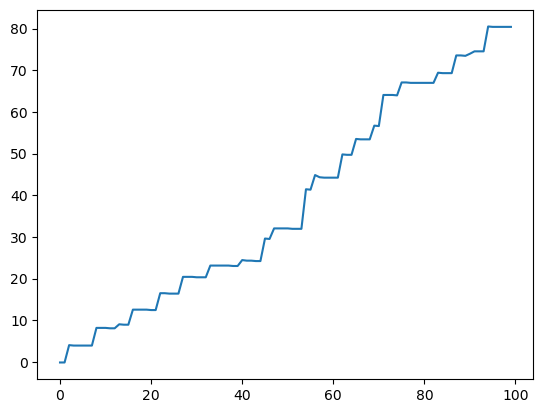

In [20]:
# d)
test_model = Model(market=Market(test_data),agent=agent)
test_P = Policy(test_model,Q)
test_episode = test_model.market.init_episode(0)
test_evaluation = test_P.evaluate(test_episode)

plt.plot(np.arange(test_data.episode_len-1)[:100], test_evaluation['reward'].cumsum()[:100])

In [ ]:
# c) compare with MC-method
Q2 = train_model.generate_Q()

train_P = Policy(train_model,Q2)
val_P = Policy(val_model,Q2)
test_P = Policy(test_model,Q2)

In [ ]:
# please check the time required for algorithms to perform 
# specified EPOCH and EPISODES

In [ ]:
%%time

EXPLORATION_EPSILON = 0.8 # FOR b)

V = dict()

val_pnl_history = list()
minimal_improvement = 0

for epoch in range(TD_N_EPOCHS):
    # calculate value of each (state,action) cell
    # first visit algorithm
    
    train_episodes = list()
    for i in range(TD_N_EPISODES): 
        train_episode = train_model.market.init_episode()
        train_episodes.append(train_episode)
        run = train_P.run(train_episode,EXPLORATION_EPSILON/(i/10+1)) # <= b)
        
        #==========#
        #  a)
        #==========#
        # change first visit => every visit
        pairs_storage = pd.DataFrame( [zip(run['state'], run['action'])] ).T
        for item in pd.unique(pairs_storage.iloc[:,0]): #to_numpy():
            item_count = pairs_storage[pairs_storage.iloc[:,0] == item].count()[0]
            #print(f'item = {item}, count = {item_count}')
            
            t = run[(run.state==item[0])&(run.action==item[1])].index
            #print(f't = {t}')

            total_value = 0
            for t_step in t:
                r = run.loc[t_step:].iloc[1:].reward.values
                f = np.power(MC_GAMMA,np.arange(0,r.size))
                total_value += (r * f).sum()
            total_value /= item_count
            #print(total_value)
            #================#
                
            if tuple(item) not in V:
                V[tuple(item)] = list()

            V[tuple(item)].append(total_value)

    # refresh values of Q
    for (state,action),vals in V.items():
        Q2[state,action] = np.mean(vals)
    
    best_total_reward = None
    best_evaluation = None
    for train_episode in train_episodes:
        train_evaluation = train_P.evaluate(train_episode)
        current_total_reward = train_evaluation['reward'].sum()
        if best_total_reward is None or current_total_reward > best_total_reward:
            best_total_reward = current_total_reward
            best_evaluation = train_evaluation
    
    val_evaluation = val_P.evaluate(val_episode)
    
    val_pnl_history.append(val_evaluation['reward'].sum())
    
    # c) criterion of stopping
    # if improvement is less than minimal_improvement / 3 => stop learning
    if epoch > 1:
        if abs( val_pnl_history[-1] - val_pnl_history[-2] ) < minimal_improvement / 3:
            break
        minimal_improvement = min(minimal_improvement, abs(val_pnl_history[-1] - val_pnl_history[-2]))
    
    # plot
    clear_output()
    
    fix,ax = plt.subplots(2,2,figsize=(25,8))
    
    ax[0,0].plot(best_evaluation['reward'].cumsum())
    ax[0,0].set_title('Best training episode')
    
    ax[0,1].plot(val_evaluation['reward'].cumsum())
    ax[0,1].set_title('Validation set')
    
    ax[1,0].plot(val_pnl_history)
    ax[1,0].set_title('Validation PNL history')
    ax[1,0].set_xlabel('Epoch #')
    ax[1,0].set_ylabel('PNL')
    
    sns.heatmap(Q2.T,ax=ax[1,1])
    ax[1,1].invert_yaxis()
    ax[1,1].set_title('Policy')
    
    plt.show()

In [ ]:
# b)
test_model = Model(market=Market(test_data),agent=agent)
test_P = Policy(test_model,Q2)
test_episode = test_model.market.init_episode(0)
test_evaluation = test_P.evaluate(test_episode)

plt.plot(np.arange(test_data.episode_len-1)[:100], test_evaluation['reward'].cumsum()[:100])